# KNN + SMOTE - Stress Level Detection

Implementasi KNN dengan SMOTE untuk mengatasi ketidakseimbangan kelas dalam klasifikasi tingkat stress.

In [42]:
!pip install --upgrade imbalanced-learn
!pip install --upgrade scikit-learn
!pip install pandas
!pip install matplotlib
!pip install seaborn

  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
    Uninstalling scikit-learn-1.7.1:
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
    Uninstalling scikit-learn-1.7.1:
      Successfully uninstalled scikit-learn-1.7.1
      Successfully uninstalled scikit-learn-1.7.1
  Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl (8.6 MB)
  Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl (8.6 MB)
  Atte

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("✅ Library berhasil diimport")

✅ Library berhasil diimport


## 1. Data Loading dan Preprocessing

In [44]:
FILE_PATH = './dataset/fix dataset 1031.csv'

# Read CSV with semicolon as separator and handle mixed decimal separators
df = pd.read_csv(FILE_PATH, sep=';', decimal='.')
dataset = df.copy()

print("Dataset shape:", dataset.shape)
display(dataset.head())

Dataset shape: (1096, 13)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1.0,Male,27.0,Software Engineer,06.01,6.0,42.0,6.0,Overweight,126/83,77.0,4200.0,NaN
1,2.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,NaN
2,3.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,NaN
3,4.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea
4,5.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea


In [45]:
# Fill missing values in Sleep Disorder with 'Normal'
dataset['Sleep Disorder'] = dataset['Sleep Disorder'].fillna('Normal')

# Split Blood Pressure column
if 'Blood Pressure' in dataset.columns:
    dataset[['Systolic', 'Diastolic']] = dataset['Blood Pressure'].str.split('/', expand=True)
    dataset['Systolic'] = pd.to_numeric(dataset['Systolic'], errors='coerce')
    dataset['Diastolic'] = pd.to_numeric(dataset['Diastolic'], errors='coerce')
    dataset = dataset.drop('Blood Pressure', axis=1)

# Clean numeric columns
kolom_numerik = ["Sleep Duration", "Heart Rate", "Daily Steps", "Systolic", "Diastolic"]
for col in kolom_numerik:
    if col in dataset.columns:
        dataset[col] = dataset[col].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

print("✅ Data preprocessing selesai")

✅ Data preprocessing selesai


## 2. Target Encoding dan Feature Selection

In [46]:
# Label encoding for target
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(dataset['Sleep Disorder'])

print("Target classes:", label_encoder.classes_)
print("Encoded values:", np.unique(target_encoded))

# Show class distribution BEFORE SMOTE
print("\n=== DISTRIBUSI KELAS BEFORE SMOTE ====")
class_counts_before = pd.Series(target_encoded).value_counts().sort_index()
for i, count in enumerate(class_counts_before):
    print(f"{label_encoder.classes_[i]}: {count} samples")

total_before = len(target_encoded)
print(f"\nTotal samples before SMOTE: {total_before}")

Target classes: ['Insomnia' 'Normal' 'Sleep Apnea']
Encoded values: [0 1 2]

=== DISTRIBUSI KELAS BEFORE SMOTE ====
Insomnia: 296 samples
Normal: 503 samples
Sleep Apnea: 297 samples

Total samples before SMOTE: 1096


In [47]:
# Select features
feature_columns = ["Gender", "Age", "Occupation", "Sleep Duration", "Quality of Sleep", 
                  "Physical Activity Level", "Stress Level", "BMI Category", "Systolic", "Diastolic"]

# Filter only existing columns
available_features = [col for col in feature_columns if col in dataset.columns]
features = dataset[available_features]

print("Selected features:", available_features)
print("Features shape:", features.shape)

Selected features: ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Systolic', 'Diastolic']
Features shape: (1096, 10)


## 3. Data Splitting

In [48]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target_encoded, test_size=0.2, random_state=42, stratify=target_encoded
)

print("=== DATA SPLIT ====")
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

print("\nDistribusi y_train BEFORE SMOTE:")
train_dist_before = pd.Series(y_train).value_counts().sort_index()
for i, count in enumerate(train_dist_before):
    print(f"{label_encoder.classes_[i]}: {count} samples")

=== DATA SPLIT ====
Training set: 876 samples
Test set: 220 samples

Distribusi y_train BEFORE SMOTE:
Insomnia: 237 samples
Normal: 402 samples
Sleep Apnea: 237 samples


## 4. Pipeline Setup dengan SMOTE

In [49]:
# Define numerical and categorical features
numerical_features = [col for col in available_features if features[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in available_features if features[col].dtype == 'object']

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Create preprocessors
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

print("✅ Preprocessor pipeline created")

Numerical features: ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Systolic', 'Diastolic']
Categorical features: ['Gender', 'Occupation', 'BMI Category']
✅ Preprocessor pipeline created


## 5. SMOTE Application

In [50]:
# Apply preprocessing to see the effect of SMOTE clearly
X_train_processed = preprocessor.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("=== COMPARISON BEFORE vs AFTER SMOTE ====")
print("\nBEFORE SMOTE:")
for i, count in enumerate(train_dist_before):
    print(f"{label_encoder.classes_[i]}: {count} samples")
print(f"Total: {len(y_train)} samples")

print("\nAFTER SMOTE:")
train_dist_after = pd.Series(y_train_smote).value_counts().sort_index()
for i, count in enumerate(train_dist_after):
    print(f"{label_encoder.classes_[i]}: {count} samples")
print(f"Total: {len(y_train_smote)} samples")

# Calculate increase
print("\nINCREASE PER CLASS:")
for i in range(len(label_encoder.classes_)):
    before = train_dist_before.iloc[i] if i < len(train_dist_before) else 0
    after = train_dist_after.iloc[i] if i < len(train_dist_after) else 0
    increase = after - before
    print(f"{label_encoder.classes_[i]}: +{increase} samples (from {before} to {after})")

=== COMPARISON BEFORE vs AFTER SMOTE ====

BEFORE SMOTE:
Insomnia: 237 samples
Normal: 402 samples
Sleep Apnea: 237 samples
Total: 876 samples

AFTER SMOTE:
Insomnia: 402 samples
Normal: 402 samples
Sleep Apnea: 402 samples
Total: 1206 samples

INCREASE PER CLASS:
Insomnia: +165 samples (from 237 to 402)
Normal: +0 samples (from 402 to 402)
Sleep Apnea: +165 samples (from 237 to 402)


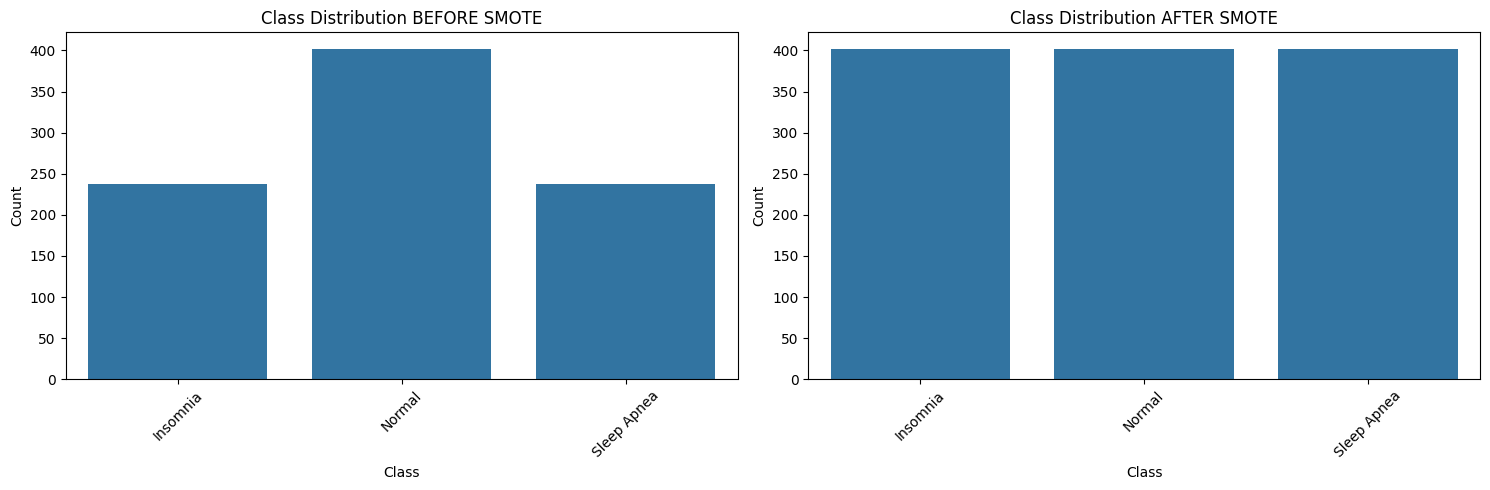

In [51]:
# Visualize class distribution before and after SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Before SMOTE
before_data = pd.DataFrame({
    'Class': [label_encoder.classes_[i] for i in train_dist_before.index],
    'Count': train_dist_before.values
})
sns.barplot(data=before_data, x='Class', y='Count', ax=ax1)
ax1.set_title('Class Distribution BEFORE SMOTE')
ax1.tick_params(axis='x', rotation=45)

# After SMOTE
after_data = pd.DataFrame({
    'Class': [label_encoder.classes_[i] for i in train_dist_after.index],
    'Count': train_dist_after.values
})
sns.barplot(data=after_data, x='Class', y='Count', ax=ax2)
ax2.set_title('Class Distribution AFTER SMOTE')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. KNN + SMOTE Training

In [52]:
# Create KNN + SMOTE pipeline
knn_smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
])

# Train the model
print("Training KNN + SMOTE model...")
knn_smote_pipeline.fit(X_train, y_train)
print("✅ Model training completed")

Training KNN + SMOTE model...
✅ Model training completed


## 7. Model Evaluation

In [53]:
# Make predictions
y_pred_smote = knn_smote_pipeline.predict(X_test)

# Calculate accuracy
accuracy_smote = accuracy_score(y_test, y_pred_smote)

print("=== HASIL EVALUASI KNN + SMOTE ====")
print(f"Akurasi: {accuracy_smote:.4f} ({accuracy_smote*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, target_names=label_encoder.classes_))

=== HASIL EVALUASI KNN + SMOTE ====
Akurasi: 0.9091 (90.91%)

Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.91      0.90      0.91        59
      Normal       0.91      0.91      0.91       101
 Sleep Apnea       0.90      0.92      0.91        60

    accuracy                           0.91       220
   macro avg       0.91      0.91      0.91       220
weighted avg       0.91      0.91      0.91       220



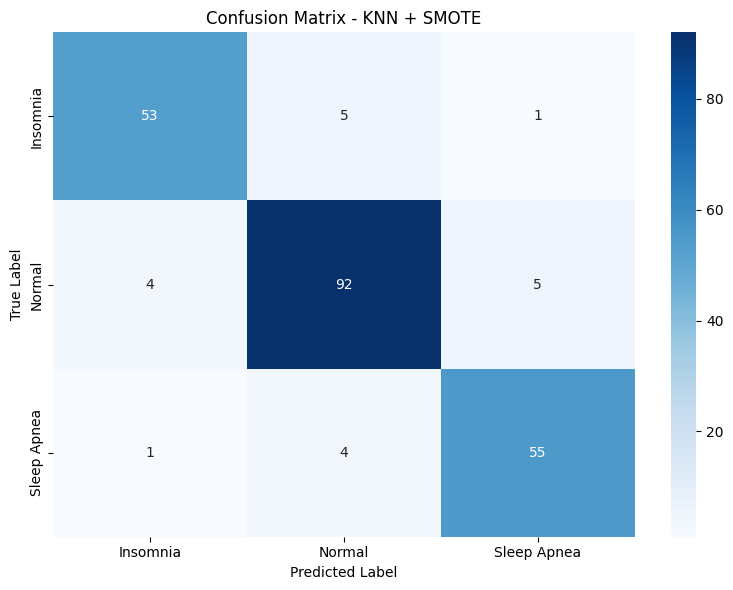

In [54]:
# Confusion Matrix
cm_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_smote, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - KNN + SMOTE")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 8. Testing Different K Values dengan SMOTE

In [55]:
# Test different k values with SMOTE
k_values = range(1, 21)
accuracies_smote = []

print("Testing different k values with SMOTE...")
for k in k_values:
    knn_smote_pipeline.set_params(knn__n_neighbors=k)
    knn_smote_pipeline.fit(X_train, y_train)
    y_pred_k = knn_smote_pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies_smote.append(acc)
    print(f"k={k}: Accuracy = {acc:.4f}")

# Find best k for SMOTE
best_k_smote = k_values[np.argmax(accuracies_smote)]
best_accuracy_smote = max(accuracies_smote)

print(f"\n=== BEST K VALUE untuk KNN + SMOTE ====")
print(f"Best k: {best_k_smote}")
print(f"Best accuracy: {best_accuracy_smote:.4f} ({best_accuracy_smote*100:.2f}%)")

Testing different k values with SMOTE...
k=1: Accuracy = 0.8909
k=2: Accuracy = 0.8909
k=3: Accuracy = 0.9136
k=4: Accuracy = 0.9045
k=5: Accuracy = 0.9091
k=6: Accuracy = 0.9318
k=7: Accuracy = 0.9227
k=8: Accuracy = 0.9227
k=9: Accuracy = 0.9227
k=5: Accuracy = 0.9091
k=6: Accuracy = 0.9318
k=7: Accuracy = 0.9227
k=8: Accuracy = 0.9227
k=9: Accuracy = 0.9227
k=10: Accuracy = 0.9318
k=11: Accuracy = 0.9273
k=12: Accuracy = 0.9318
k=13: Accuracy = 0.9136
k=14: Accuracy = 0.9182
k=15: Accuracy = 0.9045
k=16: Accuracy = 0.9091
k=17: Accuracy = 0.9091
k=18: Accuracy = 0.9091
k=10: Accuracy = 0.9318
k=11: Accuracy = 0.9273
k=12: Accuracy = 0.9318
k=13: Accuracy = 0.9136
k=14: Accuracy = 0.9182
k=15: Accuracy = 0.9045
k=16: Accuracy = 0.9091
k=17: Accuracy = 0.9091
k=18: Accuracy = 0.9091
k=19: Accuracy = 0.9000
k=20: Accuracy = 0.9045

=== BEST K VALUE untuk KNN + SMOTE ====
Best k: 6
Best accuracy: 0.9318 (93.18%)
k=19: Accuracy = 0.9000
k=20: Accuracy = 0.9045

=== BEST K VALUE untuk KNN

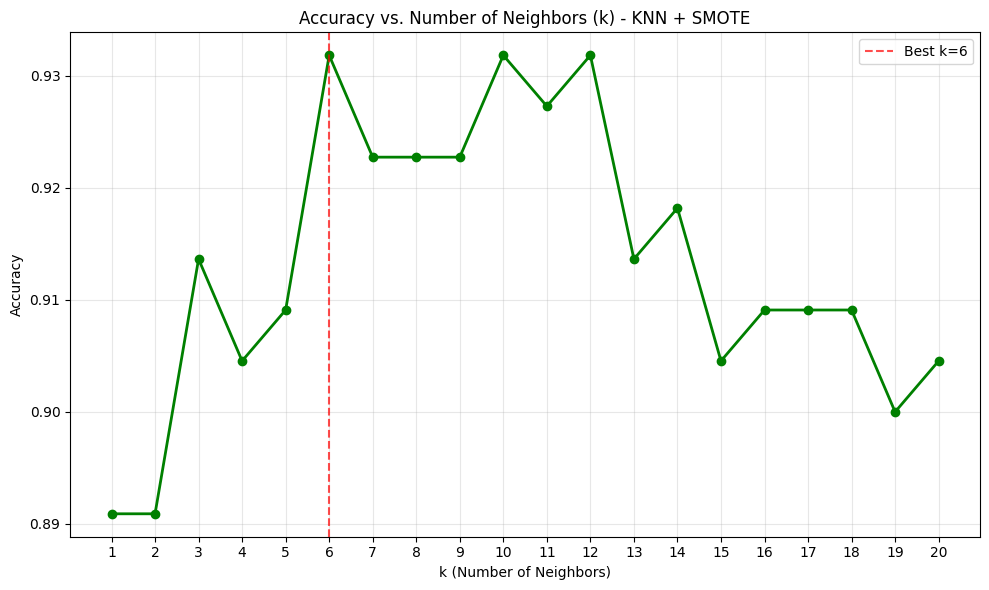

In [56]:
# Plot accuracy vs k for SMOTE
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies_smote, marker='o', linewidth=2, markersize=6, color='green')
plt.axvline(x=best_k_smote, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k_smote}')
plt.title('Accuracy vs. Number of Neighbors (k) - KNN + SMOTE')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(k_values)
plt.tight_layout()
plt.show()

## 9. Final Model dengan Best K

In [57]:
# Train final model with best k
final_knn_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=best_k_smote))
])

final_knn_smote.fit(X_train, y_train)
final_pred_smote = final_knn_smote.predict(X_test)
final_accuracy_smote = accuracy_score(y_test, final_pred_smote)

print("=== FINAL MODEL PERFORMANCE (KNN + SMOTE) ====")
print(f"Final model dengan k={best_k_smote}")
print(f"Final accuracy: {final_accuracy_smote:.4f} ({final_accuracy_smote*100:.2f}%)")
print("\nFinal Classification Report:")
print(classification_report(y_test, final_pred_smote, target_names=label_encoder.classes_))

=== FINAL MODEL PERFORMANCE (KNN + SMOTE) ====
Final model dengan k=6
Final accuracy: 0.9318 (93.18%)

Final Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.96      0.88      0.92        59
      Normal       0.91      0.97      0.94       101
 Sleep Apnea       0.95      0.92      0.93        60

    accuracy                           0.93       220
   macro avg       0.94      0.92      0.93       220
weighted avg       0.93      0.93      0.93       220



## 10. Comparison with Original Data

In [58]:
# Train KNN without SMOTE for comparison
knn_original = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=best_k_smote))
])

knn_original.fit(X_train, y_train)
pred_original = knn_original.predict(X_test)
accuracy_original = accuracy_score(y_test, pred_original)

print("=== COMPARISON: KNN vs KNN + SMOTE ====")
print(f"KNN Original (k={best_k_smote}): {accuracy_original:.4f} ({accuracy_original*100:.2f}%)")
print(f"KNN + SMOTE (k={best_k_smote}): {final_accuracy_smote:.4f} ({final_accuracy_smote*100:.2f}%)")
print(f"Improvement: {(final_accuracy_smote - accuracy_original)*100:.2f} percentage points")

=== COMPARISON: KNN vs KNN + SMOTE ====
KNN Original (k=6): 0.9318 (93.18%)
KNN + SMOTE (k=6): 0.9318 (93.18%)
Improvement: 0.00 percentage points


## Summary

**KNN + SMOTE Results:**
- **Data before SMOTE**: Class distribution as shown above
- **Data after SMOTE**: Balanced class distribution
- **Best k value**: Determined through systematic testing
- **Performance improvement**: Comparison with original KNN
- **SMOTE Impact**: Addresses class imbalance by generating synthetic samples